**Raw data has the following columns:**

[ CAR_ID | SPEED | RPM | IGNITION | PACKET_SENT_AT ]

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta

**Reading data, dropping cars with shuted down engine:**

In [0]:
data = pd.read_csv('Path_to_data', parse_dates=['packet_sent_at'])

In [0]:
data.drop(data.loc[(data.ignition == 0) | (data.rpm == 0)].index, inplace=True)

**Calculating acceleration**

In [0]:
def get_accel(row):
  k = 1000/3600.
  try:
    return ((row.speed - row.speed_before)*k) / \
            (row.packet_sent_at - row.packet_sent_at_before).total_seconds()
  except (TypeError):
    return np.nan
  except (ZeroDivisionError):
    return np.nan
  

In [0]:
%%time
import sys

cars = defaultdict()
i = 0

for car in data.ar_id.unique():
  cars[car] = data.loc[data.ar_id == car].sort_values(by=['packet_sent_at'])
  cars[car]['speed_before'] = np.nan
  cars[car]['speed_before'] = cars[car].speed.shift(1)
  cars[car]['packet_sent_at_shifted'] = np.nan
  cars[car]['packet_sent_at_before'] = cars[car].packet_sent_at.shift(1)
  cars[car]['accel'] = cars[car].apply(get_accel, axis=1)
  
  i += 1
  sys.stdout.write('\r')
  sys.stdout.write('{} of {} processed'.format(i, len(data.ar_id.unique())))
  sys.stdout.flush()


332 of 332 processed
CPU times: user 1min 47s, sys: 909 ms, total: 1min 47s
Wall time: 1min 47s


**Proposed metric for driving style evaluating:** *sum( |accel| > thresh ) / distance*


In [0]:
def evaluate_score(car_data, thresh):
  score = car_data.loc[abs(car_data.accel) > thresh].shape[0]
  return (score / (car_data.mileage.max() - car_data.mileage.min()))

In [0]:
threshold = 5
scores = pd.DataFrame(index=range(len(cars.keys())),
                      columns=['car_id', 'score'])
scores.car_id = cars.keys()
i = 0
for car in cars.keys():
  scores.at[scores.loc[scores.car_id == car].index, 'score'] = evaluate_score(cars[car], threshold)

  i += 1
  sys.stdout.write('\r')
  sys.stdout.write('{} of {} processed'.format(i, len(cars.keys())))
  sys.stdout.flush()

scores.score = scores.score.astype('float32')

332 of 332 processed

Text(0.5,1,'Driving score histogram')

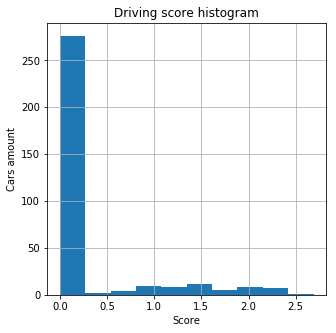

In [0]:
fig, ax = plt.subplots(1, figsize=(5, 5))
scores.score.hist(ax=ax)
ax.set_xlabel('Score')
ax.set_ylabel('Cars amount')
ax.set_title('Driving score histogram')

**Agregating data by mean and std**

In [0]:
agr_data = pd.DataFrame(index=range(len(cars.keys())),
                        columns=['car_id', 'spd_mean', 'rpm_mean', 'spd_std', 'rpm_std'])
i = 0
for car_id in cars.keys():
  row = [car_id,
         float(cars[car_id].speed.mean()), float(cars[car_id].rpm.mean()),
         float(cars[car_id].speed.std()),  float(cars[car_id].rpm.std())]
  agr_data.iloc[i] = row
  i += 1
  

In [0]:
agr_data.spd_mean = agr_data.spd_mean.astype('float32')
agr_data.rpm_mean = agr_data.rpm_mean.astype('float32')
agr_data.spd_std  = agr_data.spd_std.astype('float32')
agr_data.rpm_std  = agr_data.rpm_std.astype('float32')

Text(0.5,1,'Standard deviation of rpm')

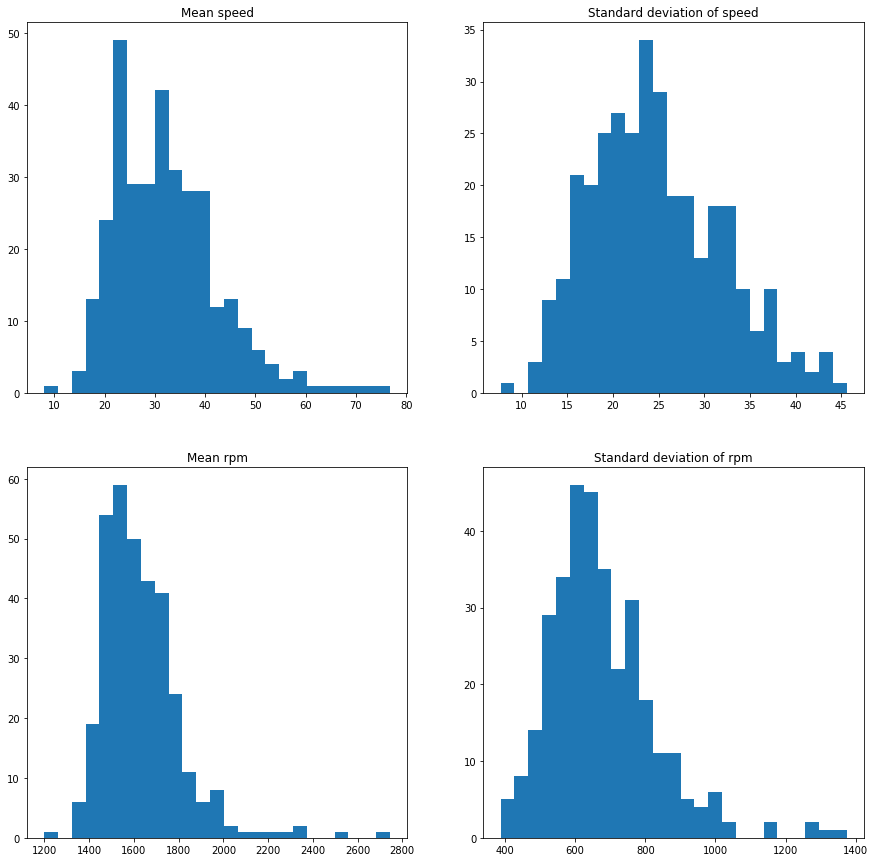

In [0]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0, 0].hist(agr_data.spd_mean, bins=25)
ax[0, 0].set_title('Mean speed')
ax[0, 1].hist(agr_data.spd_std, bins=25)
ax[0, 1].set_title('Standard deviation of speed')
ax[1, 0].hist(agr_data.rpm_mean, bins=25)
ax[1, 0].set_title('Mean rpm')
ax[1, 1].hist(agr_data.rpm_std, bins=25)
ax[1, 1].set_title('Standard deviation of rpm')
